In [1]:
#This notebook is to assess and compare existing methods for receipt OCR to construct a new process better suited to my specific problem. 
#It may use existing datasets and techniqus for comparison

Notes

Usually pytesseract is effective only for high resolution images. 
Certain morphological operations such as dilation, erosion, OTSU binarization can help increase in pytesseract performance.

In [2]:
#Imports
import re
import cv2
import pytesseract
import pytesseract

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [3]:
#Initialise Methods

#Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

#Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible
#Approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

#Find 4 points of receipt
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
        
#Convert 4 points into lines / rect      
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

#Original receipt with wrapped perspective
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

#Threshold image
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

# Original Input Receipt

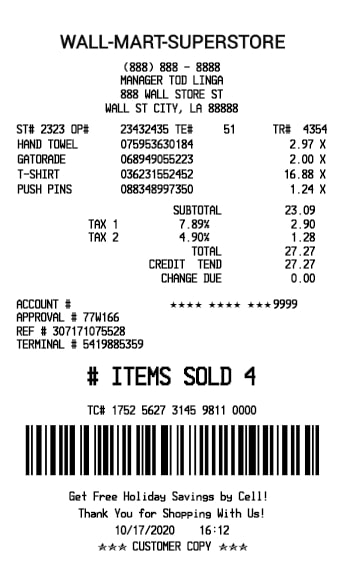

In [4]:
# Sample file out of the dataset
#dummy 01 : image on white background
#dummy 02 : image on gradient backgound
#dummy 03 : random reciept
#dummy 04 : random reciept
#Hits 02 and 09
file_name = '/home/sontb/Project/receipt_reader/train_images/standard-grocery-receipt-template.jpg'

img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img

# Step 1: Receipt Contour Detection
In order to find receipt contour, standart edge detection preprocessing is applied:

    1.1. Convert image to grayscale
    1.2. Apply Gaussian filter 5x5 to get rid of noise
    1.3. Run Canny edge detector


In [5]:
image = cv2.imread(file_name)

#Downscale image.
#Finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

# 1.1. Convert image to grayscale

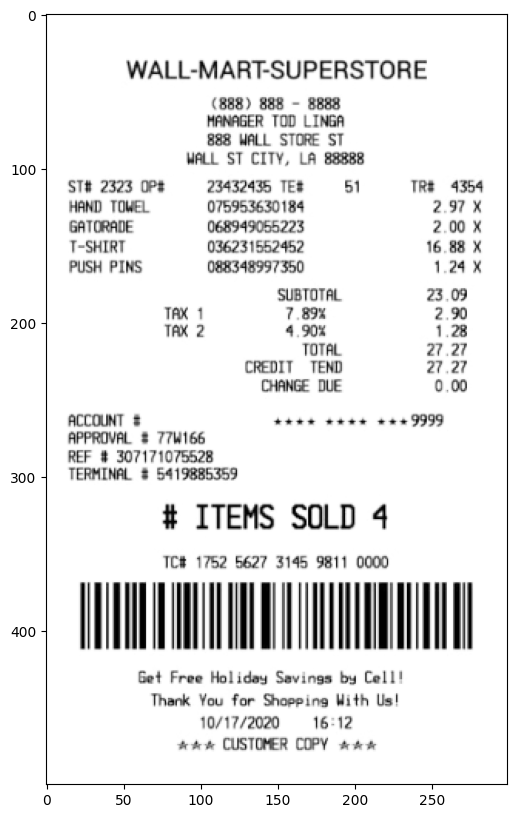

In [6]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

# 1.2. Get rid of noise with Gaussian Blur filter

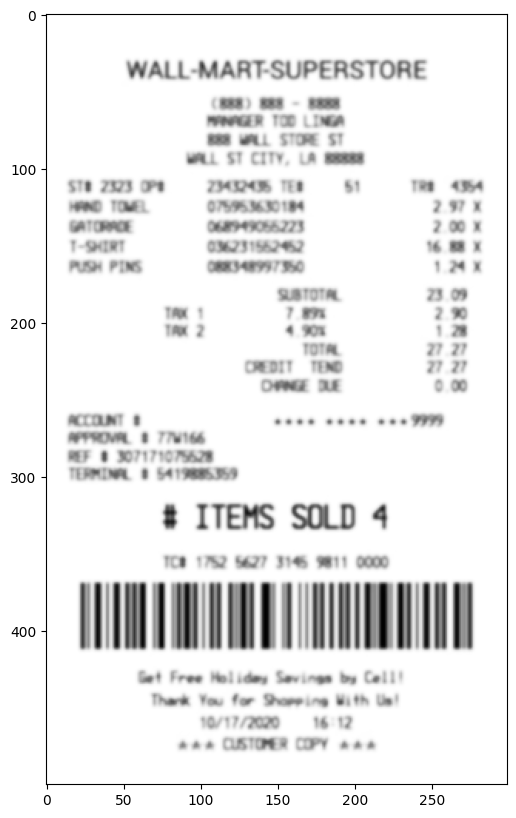

In [7]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

# Apply Dilation to Detect Regions

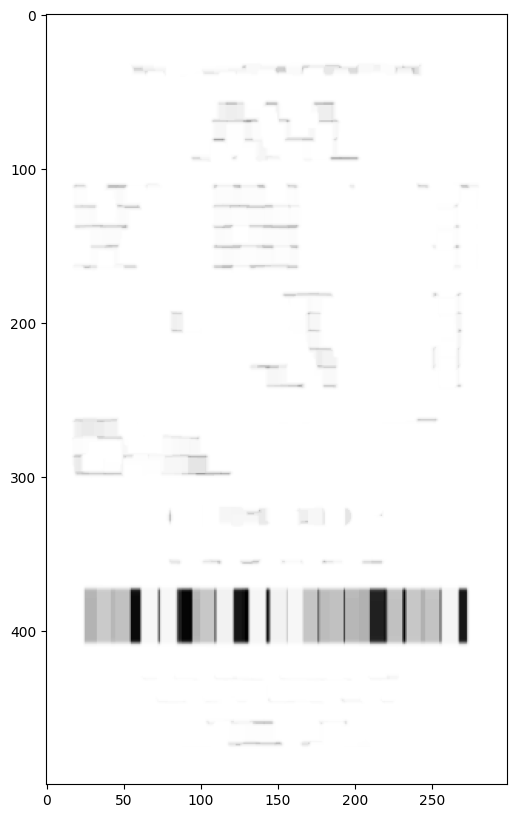

In [8]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

> If on a white backgroud then contours cannot be detected correctly

# Apply Canny Edge Detection

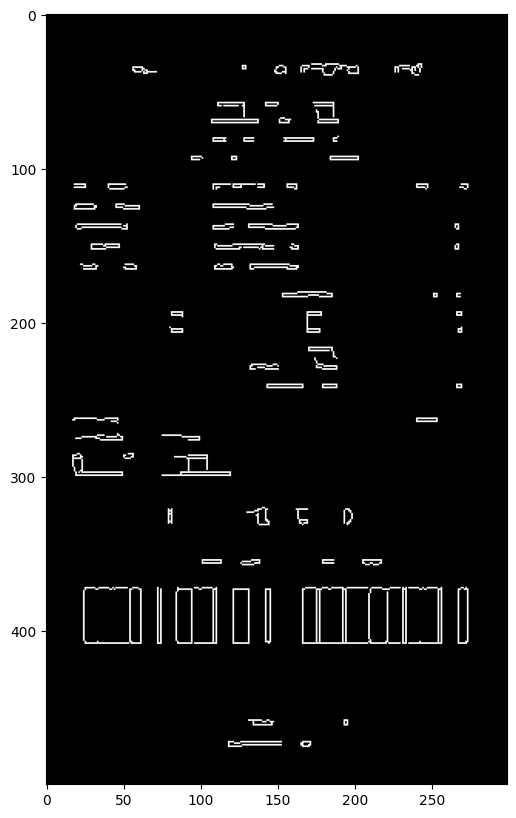

In [9]:
edged = cv2.Canny(dilated, 50, 125, apertureSize=3)
plot_gray(edged)

# Detect all contours in Canny-edged image


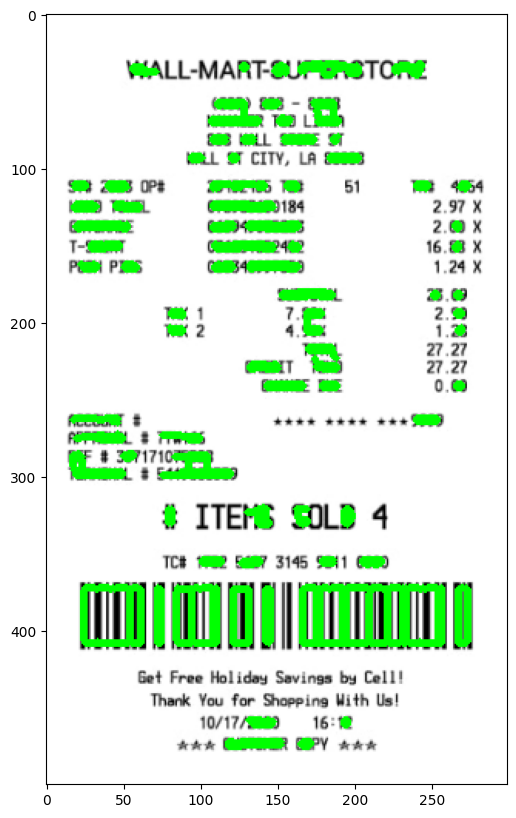

In [10]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

To find the contour of receipt we use of two heuristics / conditions:

    receipt is the largest contour whithin image
    receipt is expected to be of a rectangular shape

We will start with the first heuristic by getting TOP 1 largest contours.


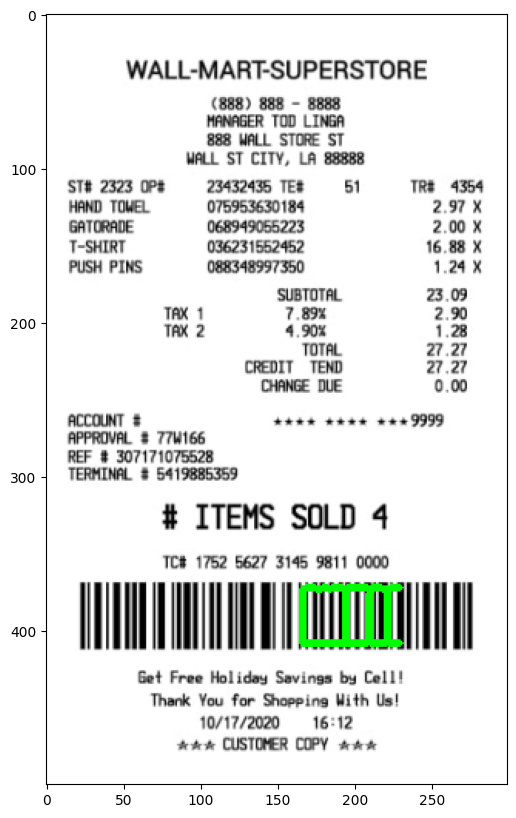

In [11]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

Vertices have been detected at a pixel level

In [12]:
get_receipt_contour(largest_contours)

> It is also important to get down to just four contour points, as we will need them for perspective restoration

In [15]:
receipt_contour = get_receipt_contour(largest_contours)
print(receipt_contour)

None


# Display the Image with Overlayed Contour

In [14]:
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/drawing.cpp:2634: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


# Cropping and perspective restoration

We will make use of cv2.warpPerspective to restore perspective of the receipt.

    convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
    use rectangle points to calculate destination points of the "scanned" view
    feed destination points into cv2.getPerspectiveTransform to calculate transformation matrix
    and finally use cv2.warpPerspective to restore the perspective!



# Display wrapped perspecive of receipt

In [ ]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

AttributeError: 'NoneType' object has no attribute 'reshape'

This images still has a lot of light and shading which could affect the OCR model

# Threshold prepare image for OCR

This mimics a scanned image. Attempts to increase OCR detection

# Computer Vision: Image Pre-Processing Model Output

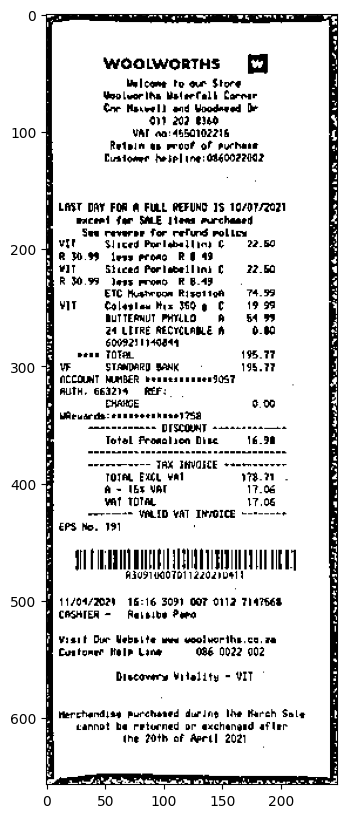

In [ ]:
result = bw_scanner(scanned)
plot_gray(result)

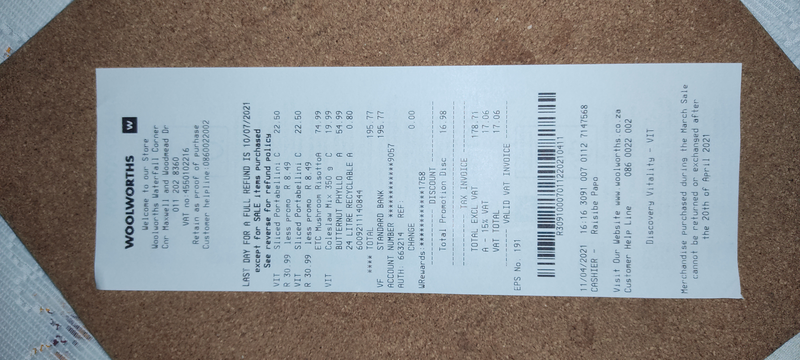

In [ ]:
file_name = '/home/sontb/Project/receipt_reader/train_images/standard-grocery-receipt-template.jpg'

img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img


In [ ]:
#Save image locally
output = Image.fromarray(result)
output.save('result.png')

## OCR MODEL

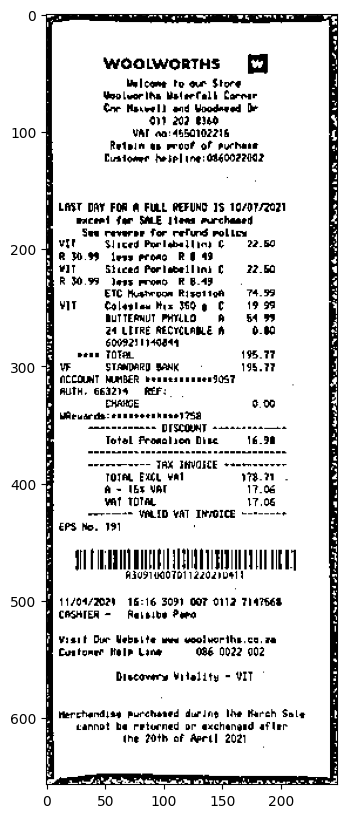

In [ ]:
img
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

# Text box detection

Bounding box looks for dictionaty words

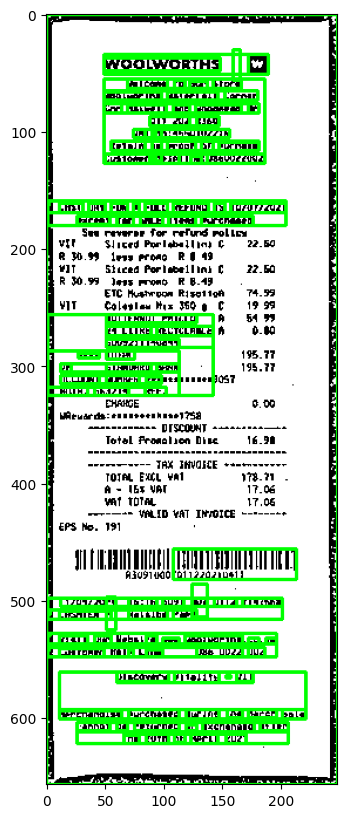

In [ ]:


d = pytesseract.image_to_data(image, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)



# Text recognition

In [ ]:
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(image, config=custom_config)
print(extracted_text)

wootwortHs § [J :
nlcane to 0 Store
eotearina Vstertlh Corner :
Gor Ravel) 9nd Vodened Be
Nt 22 so
vat on s0t022t6
Retain on root af ruchane :
eaten ete ie 0860022002
J Lesr nor Fon cue eerune 35 1o/orsze21
acral foc SME Iowa surchased
Seu ceveron for refed policy
vat Sid portabettnen 622-60
230.99 “less rong ED
Ma” shee Portaeettins © 22.50
830.99 “here weed BB :
EMC haatroo Riverton 74.99
WIT Golasawies Oe C1995
Rirtemor penta ® 5 93
eeu RECHEUARE A “0.80 :
J Sconzitvsaes
A sees fora 195.77
Gon Stacen sone 1
econ Wane neeeeseeeeeS057 F
sata ccains ters
4 Ea 0.00 E
Y saeacasonntsoonnen tt
nena 9. Deena
Toto Fronslaen Blac 16.38
QT ame
Tora eck val ven
ates var 108
fet tt 106
eee
e506. 191 :
STEARNS KE
ASUSINSO} aaah DeT
d sszoerze20 16:16 5099 oor 012 rare
d CsontER =" Reinive Pore
] vsa1t Doe Website wes wotvority.co.20
I Contoner Wein Lana” 086 002 602
Discovers Vitality = #07 :
erchandis nucchaned dating the Harch Sale
annot Be returned or exchangid after
ine 2000 oF Reed 208



# Applying Regular Expressions and String handling to clean up raw data 

In [ ]:
#Lines to excluse on the receipt
exclusion_list = ["bank", "total", "promo", "vat", "change", "recyclable"]

#Words to ommit
remove_list = ["vit", "etc"]

In [ ]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['230.99 “less rong ED', 'Ma” shee Portaeettins © 22.50', '830.99 “here weed BB :', 'EMC haatroo Riverton 74.99', 'eeu RECHEUARE A “0.80 :', 'A sees fora 195.77', '4 Ea 0.00 E', 'Toto Fronslaen Blac 16.38', '] vsa1t Doe Website wes wotvority.co.20']


In [ ]:
#Apply exclusion list
food_item = []
for eachLine in regex_line:
    found = False
    for exclude in exclusion_list:
        if exclude in eachLine.lower():
            found = True
        
    if found == False:
        food_item.append(eachLine)
print(food_item)

['230.99 “less rong ED', 'Ma” shee Portaeettins © 22.50', '830.99 “here weed BB :', 'EMC haatroo Riverton 74.99', 'eeu RECHEUARE A “0.80 :', 'A sees fora 195.77', '4 Ea 0.00 E', 'Toto Fronslaen Blac 16.38', '] vsa1t Doe Website wes wotvority.co.20']


In [ ]:
#Word ommit
new_food_item_list = []
for item in food_item:
    for subToRemove in remove_list:
        item = item.replace(subToRemove, "")
        item = item.replace(subToRemove.upper(), "")
    new_food_item_list.append(item)
print(new_food_item_list)

['230.99 “less rong ED', 'Ma” shee Portaeettins © 22.50', '830.99 “here weed BB :', 'EMC haatroo Riverton 74.99', 'eeu RECHEUARE A “0.80 :', 'A sees fora 195.77', '4 Ea 0.00 E', 'Toto Fronslaen Blac 16.38', '] vsa1t Doe Website wes wotvority.co.20']


In [ ]:
#Food item cost regex
food_item_cost = []
for line in new_food_item_list:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            food_item_cost.append(possibleCost)
print(new_food_item_list)


['230.99 “less rong ED', 'Ma” shee Portaeettins © 22.50', '830.99 “here weed BB :', 'EMC haatroo Riverton 74.99', 'eeu RECHEUARE A “0.80 :', 'A sees fora 195.77', '4 Ea 0.00 E', 'Toto Fronslaen Blac 16.38', '] vsa1t Doe Website wes wotvority.co.20']


In [ ]:
#Remove cost price from food item
count = 0;
only_food_items = []
for item in new_food_item_list:
    only_alpha = ""
    for char in item:
        if char.isalpha() or char.isspace():
            only_alpha += char
            
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    only_food_items.append(only_alpha)
print(only_food_items)

['less rong ED', 'Ma shee Portaeettins', 'here weed BB', 'EMC haatroo Riverton', 'eeu RECHEUARE', 'sees fora', 'Ea', 'Toto Fronslaen Blac', 'vsat Doe Website wes wotvorityco']


In [ ]:
#Removes 2 letter words from food item
#No core food item has two letters (Most cases)
food = []
for item in only_food_items:
    # getting splits
    temp = item.split()

    # omitting K lengths
    res = [ele for ele in temp if len(ele) != 2]

    # joining result
    res = ' '.join(res)
    
    food.append(res)
print(food)

['less rong', 'shee Portaeettins', 'here weed', 'EMC haatroo Riverton', 'eeu RECHEUARE', 'sees fora', '', 'Toto Fronslaen Blac', 'vsat Doe Website wes wotvorityco']


# Optical Character Recognition Model Output

In [ ]:
#Taulate Food Item and Cost
t = PrettyTable(['Food Item', 'Cost'])
for counter in range (0,len(food)):
    t.add_row([food[counter], food_item_cost[counter]])
print(t)

+----------------------------------+--------+
|            Food Item             |  Cost  |
+----------------------------------+--------+
|            less rong             | 230.99 |
|        shee Portaeettins         | 22.50  |
|            here weed             | 830.99 |
|       EMC haatroo Riverton       | 74.99  |
|          eeu RECHEUARE           |  0.80  |
|            sees fora             | 195.77 |
|                                  |  0.00  |
|       Toto Fronslaen Blac        | 16.38  |
| vsat Doe Website wes wotvorityco |  .20   |
+----------------------------------+--------+
